In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

In [2]:
words = open("./names.txt").read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
block_size = 3 # Number of previous characters to consider to predict next character

In [4]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:s for i, s in enumerate(chars)}
itos[0] = '.'

#### Compiling Dataset

In [5]:
def build_data_set(words):
    X, Y = [], []
    for word in words:
        context = [0]*block_size
        s = ["."] + list(word) + ["."]
        for ch1, ch2 in zip(s, s[1:]):
            # print(" ".join([itos[i] for i in context]), " ---> ", ch2)
            idx = stoi[ch2]
            Y.append(idx)
            X.append(context)
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)

In [6]:
random.shuffle(words)
xtr, ytr = build_data_set(words[:int(0.8*len(words))])
xdev, ydev = build_data_set(words[int(0.8*len(words)): int(0.9*len(words))])
xte, yte = build_data_set(words[int(0.9*len(words)):])

In [7]:
print(xtr.shape)
print(xdev.shape)
print(xte.shape)

torch.Size([182463, 3])
torch.Size([22896, 3])
torch.Size([22787, 3])


#### Initializing Parameters

In [8]:
# Embedding Matrix where each word is represented by n dimensions
n = 10
C = torch.randn((27, n), requires_grad=True)

In [9]:
k = 100 # Number of neurons in hidden Layer
W1 = torch.randn((block_size*n, k), requires_grad=True)
b1 = torch.randn(k, requires_grad=True)
W2 = torch.randn((k, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

In [10]:
parameters = [C, W1, b1, W2, b2]

In [11]:
sum(p.nelement() for p in parameters)

6097

In [12]:
steps = []
lossi = []
lri = []

#### Optimization Loop

In [13]:
for i in range(200000):
    # Mini Batching of size 32
    idx = torch.multinomial(torch.arange(0, len(xtr)).float(), 32, replacement=True)

    for p in parameters:
        p.grad = None
    # Forward Propagation
    emb = (C[xtr[idx]].view(-1, block_size*n)) # Extracting embeddings and concatenating them
    h = (emb@W1 + b1).tanh() # tanh layer
    logits = h@W2 + b2 # Final layer
    loss = F.cross_entropy(logits, ytr[idx])
    # Back Propagation
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr*p.grad

    steps.append(i)
    lossi.append(loss.item())
    lri.append(lr)

print(loss)

tensor(2.1187, grad_fn=<NllLossBackward0>)


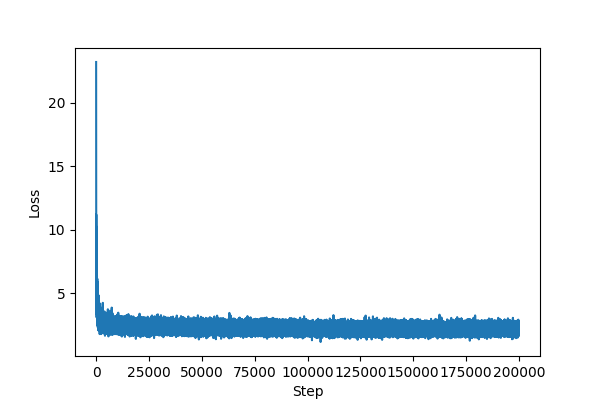

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.plot(steps, lossi)

In [15]:
# Evaluating on Validation Set
h = (C[xdev].view(-1, block_size*n))
a = (h@W1 + b1).tanh()
logits = a@W2 + b2
loss = F.cross_entropy(logits, ydev)
print(loss)

tensor(2.1946, grad_fn=<NllLossBackward0>)


### Visualising Character Embeddings

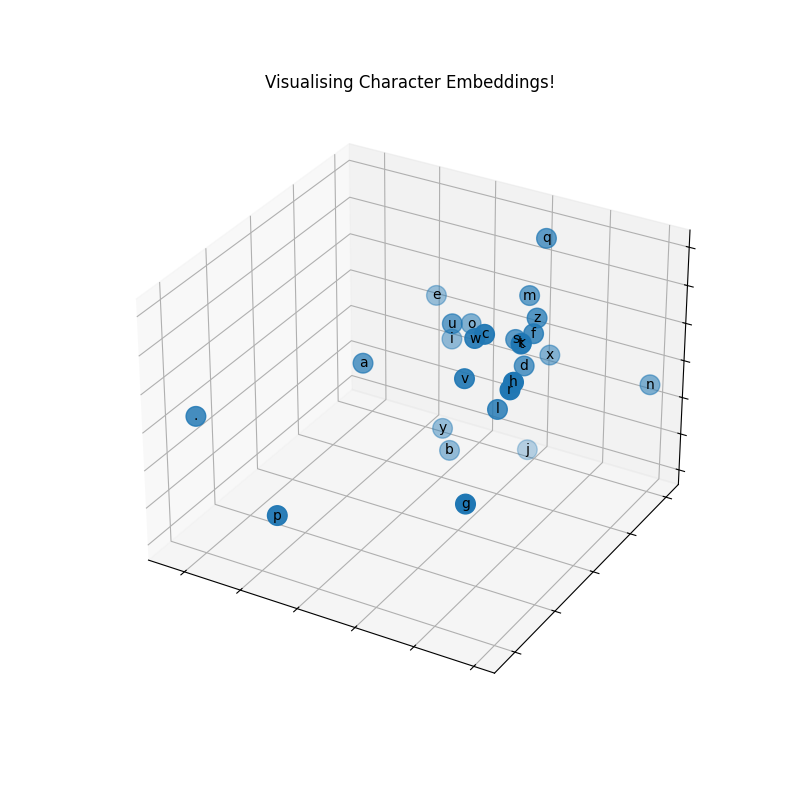

In [22]:
C_p = C.detach()
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(C_p[:,0], C_p[:,1], C_p[:,2], s=200)
ax.set_title("Visualising Character Embeddings!")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
for i in range(27):
    ax.text(C_p[i][0], C_p[i][1], C_p[i][2], itos[i], ha="center", va="center", c="black")

In [19]:

from matplotlib import animation
def update(i):
    ax.view_init(azim = 45+i*5/50)
ani = animation.FuncAnimation(fig, update, frames=720*5)
ani.save("./embeddings.mp4", dpi=200, fps=50)

In [21]:
import IPython.display
IPython.display.Video("./embeddings.mp4")